In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier  # LightGBM
from catboost import CatBoostClassifier  # CatBoost
from sklearn.ensemble import RandomForestClassifier
from time import time

In [7]:
# Load dataset
data = pd.read_csv("C:/Users/OHR.ADMIN1/Desktop/data/RAW-DATA.csv")  # Replace with your path
#data = pd.read_csv("C:/Users/Mmad/Desktop/FXPRSIG/New folder/DATA/H30-SIG-OVERAL.csv")  # Replace with your path


In [8]:
# Preprocessing
scaler = StandardScaler()

X = data.drop(columns=['ACT'])  # Drop the target variable
y = data['ACT']  # Dependent variable (1 or 0)

# ALL DATA OR PART OF IT
X = X[:]
y = y[:]


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [16]:
# Define models and parameters for GridSearchCV
models = {
    'LightGBM': (LGBMClassifier(), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'num_leaves': [31, 50, 70],
        'max_depth': [-1, 10, 20],
        'min_data_in_leaf': [20, 50, 100],
        'reg_alpha': [0.0, 0.1, 1.0],  # L1 regularization
        'reg_lambda': [0.0, 0.1, 1.0]  # L2 regularization
    }),
    'CatBoost': (CatBoostClassifier(verbose=0), {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7]  # Regularization term
    }),
    'RandomForest': (RandomForestClassifier(class_weight='balanced'), {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    })
}


In [17]:
# GridSearch with F1-score for each model
best_models = {}
for model_name, (model, params) in models.items():
    strat_time = time()
    grid = GridSearchCV(model, param_grid=params, scoring='f1', cv=5, n_jobs=-1)  # Use F1-score for imbalanced data
    grid.fit(X_train_res, y_train_res)  # Train with oversampled data (SMOTE)
    best_models[model_name] = grid.best_estimator_
    # Save the best model using joblib
    import joblib
    joblib.dump(grid.best_estimator_, f'{model_name}_best_model.pkl')
    end_time = time()
    duration = end_time - strat_time
    print(duration)
    print(f"{model_name} best parameters: {grid.best_params_}")
    



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 23501, number of negative: 23501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 47002, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
8552.346060037613
LightGBM best parameters: {'learning_rate': 0.3, 'max_depth': -1, 'min_data_in_leaf': 20, 'n_estimators': 300, 'num_leaves': 70, 'reg_alpha': 0.0, 'reg_lambda': 0.1}
1797.7493443489075
CatBoost best parameters: {'depth': 10, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
7780.862161874

In this analysis, we explored the performance of various machine learning models, specifically focusing on LightGBM, CatBoost, and RandomForest. Notably, the warnings from LightGBM regarding the parameters min_data_in_leaf and min_child_samples indicate that the current configuration is set to a minimum of 20 for both, with min_data_in_leaf taking precedence. This setting, along with the balanced dataset comprising 23,501 positive and negative instances, provides a solid foundation for effective model training.

The training dataset consisted of 47,002 samples and utilized 52 features, highlighting the complexity of the data. LightGBM exhibited optimal performance with parameters such as a learning rate of 0.3, a maximum depth of -1 (indicating no limit), and 300 estimators, resulting in a training score of approximately 8552.35. In comparison, CatBoost achieved competitive results with a depth of 10 and a learning rate of 0.1, while RandomForest showcased flexibility with 300 estimators and no maximum depth, albeit with lower scores.

Overall, the comparative analysis reveals that while LightGBM offers high performance, CatBoost and RandomForest also provide valuable alternatives depending on the specific requirements of the task at hand. The findings suggest that hyperparameter tuning remains crucial for enhancing model performance across different algorithms, underscoring the importance of systematic experimentation in machine learning workflows.

Summary table of the best parameters for each model:

| Model         | Best Parameters                                                |
|---------------|---------------------------------------------------------------|
| **LightGBM**  | `{'learning_rate': 0.3, 'max_depth': -1, 'min_data_in_leaf': 20, 'n_estimators': 300, 'num_leaves': 70, 'reg_alpha': 0.0, 'reg_lambda': 0.1}` |
| **CatBoost**  | `{'depth': 10, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}` |
| **RandomForest** | `{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}` |

In [11]:
models = {
    'LightGBM': (LGBMClassifier(learning_rate=0.3, max_depth=-1, min_data_in_leaf=20, n_estimators=300, num_leaves=70, reg_alpha=0.0, reg_lambda=0.1), {
        # Since we've set the best parameters, we can keep them in comments for reference
        'n_estimators': [300],  # Fixed to best value
        'learning_rate': [0.3],  # Fixed to best value
        'num_leaves': [70],  # Fixed to best value
        'max_depth': [-1],  # Fixed to best value
        'min_data_in_leaf': [20],  # Fixed to best value
        'reg_alpha': [0.0],  # Fixed to best value
        'reg_lambda': [0.1]  # Fixed to best value
    }),
    'CatBoost': (CatBoostClassifier(depth=10, iterations=300, l2_leaf_reg=1, learning_rate=0.1, verbose=0), {
        # Fixed parameters for consistency
        'iterations': [300],  # Fixed to best value
        'learning_rate': [0.1],  # Fixed to best value
        'depth': [10],  # Fixed to best value
        'l2_leaf_reg': [1]  # Fixed to best value
    }),
    'RandomForest': (RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2, bootstrap=False, class_weight='balanced'), {
        # Fixed parameters for consistency
        'n_estimators': [300],  # Fixed to best value
        'max_depth': [None],  # Fixed to best value
        'min_samples_split': [2],  # Fixed to best value
        'min_samples_leaf': [1],  # Fixed to best value
        'bootstrap': [False]  # Fixed to best value
    })
}


In [12]:
# GridSearch with F1-score for each model
best_models = {}
for model_name, (model, params) in models.items():
    strat_time = time()
    grid = GridSearchCV(model, param_grid=params, scoring='f1', cv=5, n_jobs=-1)  # Use F1-score for imbalanced data
    grid.fit(X_train_res, y_train_res)  # Train with oversampled data (SMOTE)
    best_models[model_name] = grid.best_estimator_
    # Save the best model using joblib
    import joblib
    joblib.dump(grid.best_estimator_, f'{model_name}_best_model.pkl')
    end_time = time()
    duration = end_time - strat_time
    print(duration)
    print(f"{model_name} best parameters: {grid.best_params_}")

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 23501, number of negative: 23501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 47002, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
6.8711838722229
LightGBM best parameters: {'learning_rate': 0.3, 'max_depth': -1, 'min_data_in_leaf': 20, 'n_estimators': 300, 'num_leaves': 70, 'reg_alpha': 0.0, 'reg_lambda': 0.1}
92.49511504173279
CatBoost best parameters: {'depth': 10, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
356.5592603683471

In [13]:
# Evaluate the best models on the test set
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

LightGBM Results:
Accuracy: 0.7477
F1-Score: 0.3309
Confusion Matrix:
[[8581 1662]
 [1497  781]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     10243
           1       0.32      0.34      0.33      2278

    accuracy                           0.75     12521
   macro avg       0.59      0.59      0.59     12521
weighted avg       0.75      0.75      0.75     12521


CatBoost Results:
Accuracy: 0.7269
F1-Score: 0.3547
Confusion Matrix:
[[8161 2082]
 [1338  940]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     10243
           1       0.31      0.41      0.35      2278

    accuracy                           0.73     12521
   macro avg       0.59      0.60      0.59     12521
weighted avg       0.76      0.73    

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


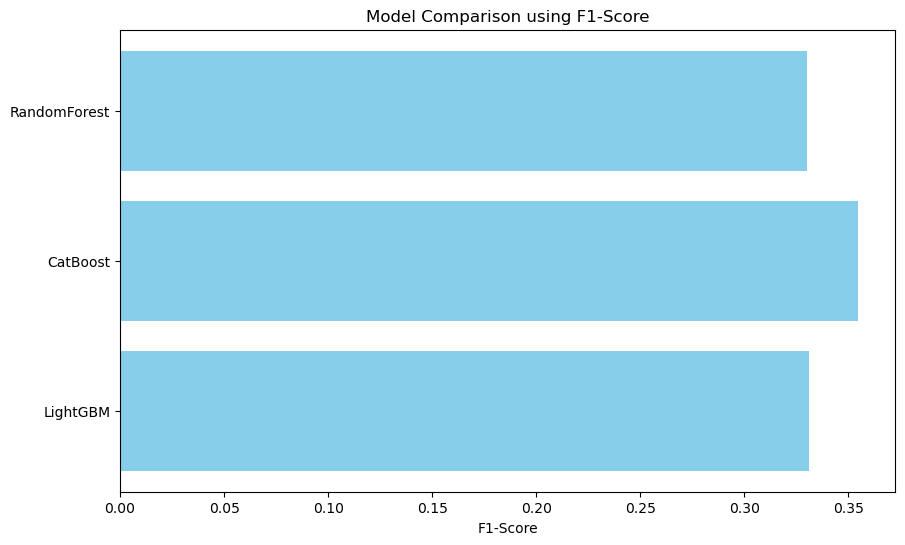

In [14]:
# Plot comparison of model performance using F1-score
f1_scores = [f1_score(y_test, model.predict(X_test)) for model in best_models.values()]
model_names = list(best_models.keys())
plt.figure(figsize=(10, 6))
plt.barh(model_names, f1_scores, color='skyblue')
plt.xlabel('F1-Score')
plt.title('Model Comparison using F1-Score')
plt.show()
